### FIN30270 Advanced Risk Management - Assignment 2

### Question 1a

In [28]:
using DataFrames, MarketData, Statistics, Ipopt, JuMP, Plots, LinearAlgebra
using  ARCHModels, Distributions, FinancialToolbox, SCIP, Printf
find(x)=findall(x1 -> x1,vec(x))

find (generic function with 1 method)

In [29]:
df=DataFrame(yahoo("^ISEQ"))

# Explicitly convert Nothing to missing
df.AdjClose = [x === nothing ? missing : x for x in df.AdjClose]

# Drop rows where AdjClose is missing
dropmissing!(df)

# Verify that no missing or Nothing values remain
println("Number of missing values after cleaning: ", sum(ismissing, df.AdjClose))
println("Number of Nothing values after cleaning: ", sum(x -> x === nothing, df.AdjClose))

# Ensure the column is of type Vector{Float64}
df.AdjClose = convert(Vector{Float64}, df.AdjClose)

# Extract the adjusted close prices
iseq_ac = df.AdjClose
iseq_ret = iseq_ac[2:end] ./ iseq_ac[1:end-1] .- 1

Number of missing values after cleaning: 0
Number of Nothing values after cleaning: 0


6993-element Vector{Float64}:
  0.006832613659897735
  0.00588712334004815
 -0.0022827518326794527
  0.01414489454370571
  0.009337605205639754
  6.09278040009098e-5
 -0.017831014419941504
  0.010743952886274721
  0.012644085122985427
  0.0005757763749132394
  ⋮
  0.005179197707715577
  0.004417293360871266
  0.004065220041789219
  0.010848497012324376
 -0.0001102558183951885
 -0.02360090391284131
  0.03434902875536938
  0.009335584615837167
 -0.010131895305522276

We begin by computing predictive daily forecasts for VaR and cVaR, assuming no GARCH(1,1) rescaling, without Gaussian assumption

Number of breaches: 437
Number of observations: 6743
Breach rate: 6.48%
Expected breach rate: 5.00%
Average VaR: 19186.93 EUR
Average Expected Shortfall (ES): 27332.03 EUR


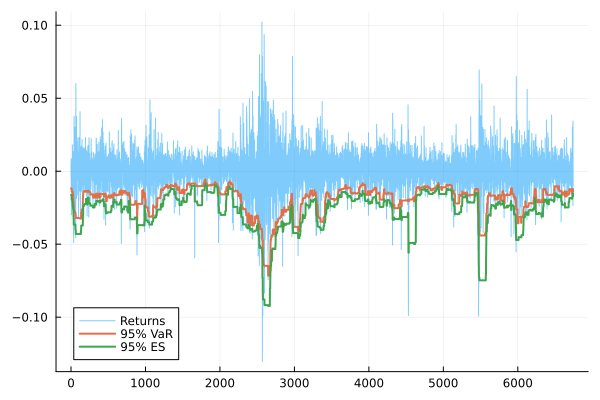

In [39]:
# Initialize arrays for VaR and ES results
var_forecasts = fill(NaN, length(iseq_ret))  # VaR forecasts
es_forecasts = fill(NaN, length(iseq_ret))   # ES forecasts
breaches = fill(false, length(iseq_ret))     # Breaches

# Start from the 251st observation
for i in 251:length(iseq_ret)
    # Get the previous 100 observations
    historical_window = iseq_ret[i-100:i-1]
    
    # Calculate 95% VaR (5th percentile since we're looking at losses)
    var_forecasts[i] = quantile(historical_window, 0.05)
    
    # Calculate 95% ES (average of returns below VaR)
    es_forecasts[i] = mean(historical_window[historical_window .< var_forecasts[i]])
    
    # Check if there's a breach (actual return is lower than VaR)
    breaches[i] = iseq_ret[i] < var_forecasts[i]
end

# Calculate the breach rate
breach_rate = mean(breaches[251:end])
num_breaches = sum(breaches[251:end])
total_obs = length(iseq_ret) - 250

# Calculate average ES and VaR
avg_var = mean(var_forecasts[251:end])
avg_es = mean(es_forecasts[251:end])

println("Number of breaches: $num_breaches")
println("Number of observations: $total_obs")
println("Breach rate: $(round(breach_rate * 100, digits=2))%")
println("Expected breach rate: 5.00%")
println("Average VaR: $(round(avg_var * -1_000_000, digits=2)) EUR")
println("Average Expected Shortfall (ES): $(round(avg_es * -1_000_000, digits=2)) EUR")

# Plot the returns, VaR, and ES
plot(iseq_ret[251:end], label="Returns", alpha=0.5)
plot!(var_forecasts[251:end], label="95% VaR", linewidth=2)
plot!(es_forecasts[251:end], label="95% ES", linewidth=2)

The breach rate (6.48%) was higher than the expected one (5.00%), suggesting that the assumed model might not be the best fit for calculating VaR. The plot closely resemble the Volatility Index (VIX), with large and sudden spikes, with a great deal of clustering. 

The Expected Shortfall (27332.03 EUR) is quite larger than the average VaR (19186.93 EUR), suggesting that there might be heavy left tail in the empirical distribution of returns. 

We now compute VaR and cVaR with Gaussian assumption:

Number of breaches: 383
Number of observations: 6743
Breach rate: 5.68%
Expected breach rate: 5.00%
Average Gaussian VaR: 19964.59 EUR
Average Gaussian ES: 25459.58 EUR


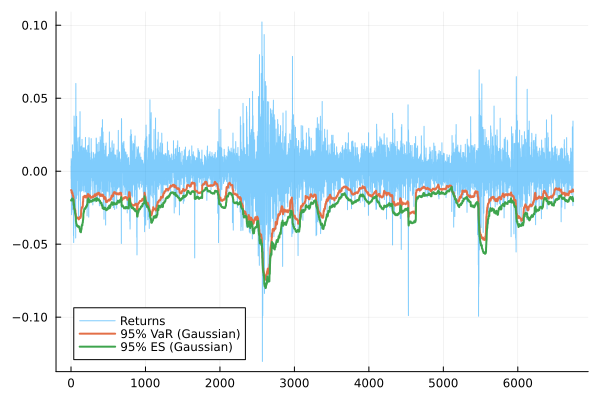

In [40]:
# Initialize arrays for Gaussian VaR and ES
var_forecasts_gauss = fill(NaN, length(iseq_ret))  # Gaussian VaR
es_forecasts_gauss = fill(NaN, length(iseq_ret))   # Gaussian ES
breaches_gauss = fill(false, length(iseq_ret))      # Breaches for Gaussian

# Start from the 251st observation
for i in 251:length(iseq_ret)
    # Get the previous 100 observations
    historical_window = iseq_ret[i-100:i-1]
    
    # Calculate Gaussian VaR and ES
    mu = mean(historical_window)
    sigma = std(historical_window)
    var_forecasts_gauss[i] = mu + sigma * quantile(Normal(), 0.05)
    es_forecasts_gauss[i] = mu + sigma * (pdf(Normal(), quantile(Normal(), 0.05)) / 0.05)

    # Check for breaches
    breaches_gauss[i] = iseq_ret[i] < var_forecasts_gauss[i]
end

# Calculate average Gaussian VaR and ES
avg_var_gauss = mean(var_forecasts_gauss[251:end])
avg_es_gauss = mean(es_forecasts_gauss[251:end])

# Calculate breach rate
breach_rate_gauss = mean(breaches_gauss[251:end])
num_breaches_gauss = sum(breaches_gauss[251:end])

println("Number of breaches: $num_breaches_gauss")
println("Number of observations: $total_obs")
println("Breach rate: $(round(breach_rate_gauss * 100, digits=2))%")
println("Expected breach rate: 5.00%")
println("Average Gaussian VaR: $(round(avg_var_gauss * -1_000_000, digits=2)) EUR")
println("Average Gaussian ES: $(round(-avg_es_gauss * -1_000_000, digits=2)) EUR")

# Plot the returns and Gaussian VaR
plot(iseq_ret[251:end], label="Returns", alpha=0.5)
plot!(var_forecasts_gauss[251:end], label="95% VaR (Gaussian)", linewidth=2)
plot!(-es_forecasts_gauss[251:end], label="95% ES (Gaussian)", linewidth=2)

We have an improvement in the breach rate, which would imply an improvement in the assumed model. The plot of the VaR and ES also appears less volatile than the last fitted model.

Again, there is some disparity between the VaR (19964.59 EUR) and the ES (25459.58 EUR), but lower than the last model, suggesting less of a heavy left tail.

We now move on to the computation with GARCH(1,1) rescaling 

Number of breaches (GARCH): 422
Number of observations: 6743
Breach rate (GARCH): 6.26%
Expected breach rate: 5.00%
Average GARCH-rescaled VaR: 19844.18 EUR
Average GARCH-rescaled ES: 28011.73 EUR


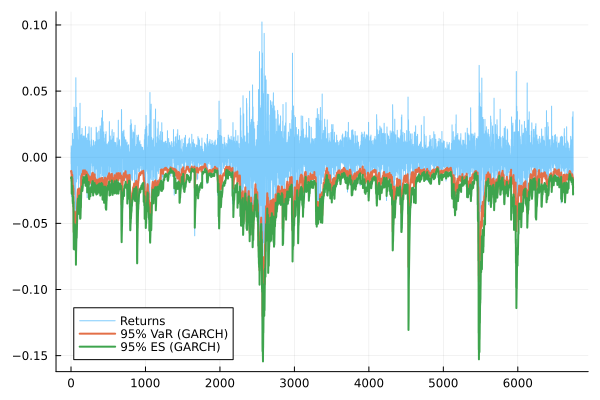

In [41]:
# Fit GARCH(1,1) model
garch_model = fit(GARCH{1,1}, iseq_ret)

# Extract fitted volatilities using the volatility function
vol_vec = volatilities(garch_model) 

# Initialize arrays for VaR and ES results
var_forecasts_garch = fill(NaN, length(iseq_ret))  # GARCH VaR
es_forecasts_garch = fill(NaN, length(iseq_ret))   # GARCH ES
breaches_garch = fill(false, length(iseq_ret))     # Breaches for GARCH VaR

# Start from the 251st observation
for i in 251:length(iseq_ret)
    # Get the previous 100 observations
    historical_window = iseq_ret[i-100:i-1]
    
    # Rescale returns by GARCH volatility
    historical_window_garch = historical_window ./ vol_vec[i-100:i-1]
    
    # Calculate GARCH-rescaled VaR and ES
    var_forecasts_garch[i] = quantile(historical_window_garch, 0.05) * vol_vec[i]
    es_forecasts_garch[i] = mean(historical_window_garch[historical_window_garch .< var_forecasts_garch[i] / vol_vec[i]]) * vol_vec[i]

    # Check for breaches
    breaches_garch[i] = iseq_ret[i] < var_forecasts_garch[i]
end

# Calculate breach rates
breach_rate_garch = mean(breaches_garch[251:end])
num_breaches_garch = sum(breaches_garch[251:end])
total_obs = length(iseq_ret) - 250

# Calculate average GARCH VaR and ES
avg_var_garch = mean(var_forecasts_garch[251:end])
avg_es_garch = mean(es_forecasts_garch[251:end])

println("Number of breaches (GARCH): $num_breaches_garch")
println("Number of observations: $total_obs")
println("Breach rate (GARCH): $(round(breach_rate_garch * 100, digits=2))%")
println("Expected breach rate: 5.00%")
println("Average GARCH-rescaled VaR: $(round(avg_var_garch * -1_000_000, digits=2)) EUR")
println("Average GARCH-rescaled ES: $(round(avg_es_garch * -1_000_000, digits=2)) EUR")

# Plot the returns and GARCH VaR
plot(iseq_ret[251:end], label="Returns", alpha=0.5)
plot!(var_forecasts_garch[251:end], label="95% VaR (GARCH)", linewidth=2)
plot!(es_forecasts_garch[251:end], label="95% ES (GARCH)", linewidth=2)

The breach rate is similar to the one seen using the historical VaR, indicating that it might not be the best model.

This is the largest disparity between VaR (19844.18 EUR) and ES (28011.73 EUR), suggesting that this model has the heaviest left tails.

Finally, we compute VaR and cVaR, with Gaussian assumption, and with GARCH(1,1) rescaling.

Number of breaches: 374
Number of observations: 6743
Breach rate: 5.35%
Expected breach rate: 5.00%
Average Gaussian VaR with GARCH: 20415.07 EUR
Average Gaussian ES with GARCH: 25547.28 EUR


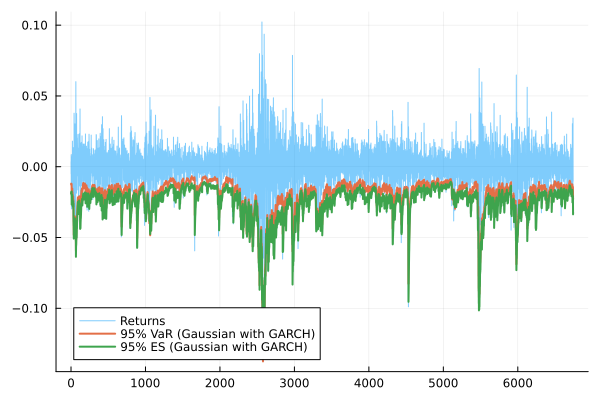

In [42]:
# Fit GARCH(1,1) model
garch_model = fit(GARCH{1,1}, iseq_ret)

# Extract fitted volatilities using the volatilities function
vol_vec = volatilities(garch_model)

# Initialize arrays for Gaussian VaR and ES
var_forecasts_gauss_garch = fill(NaN, length(iseq_ret))
es_forecasts_gauss_garch = fill(NaN, length(iseq_ret))
breaches_gauss_garch = fill(false, length(iseq_ret))     # Breaches for GARCH VaR

# Start from the 251st observation
for i in 251:length(iseq_ret)
    # Get the previous 100 observations
    historical_window = iseq_ret[i-100:i-1]
    
    # Standardized Residuals
    historical_window_garch = historical_window ./ vol_vec[i-100:i-1]
    
    # Calculation of VaR and ES
    mu = mean(historical_window_garch)
    sigma = std(historical_window_garch)
    
    var_forecasts_gauss_garch[i] = (mu + sigma * quantile(Normal(), 0.05)) * vol_vec[i]
    es_forecasts_gauss_garch[i] = (mu + sigma * (pdf(Normal(), quantile(Normal(), 0.05)) / 0.05)) * vol_vec[i]

    # Check for breaches
    breaches_gauss_garch[i] = iseq_ret[i] < var_forecasts_gauss_garch[i]
end

# Calculate average Gaussian VaR and ES
avg_var_gauss_garch = mean(var_forecasts_gauss_garch[251:end])
avg_es_gauss_garch = mean(es_forecasts_gauss_garch[251:end])

# Calculate breach rate
breach_rate = mean(breaches_gauss_garch)
num_breaches = sum(breaches_gauss_garch)
total_obs = length(iseq_ret) - 250

println("Number of breaches: $num_breaches")
println("Number of observations: $total_obs")
println("Breach rate: $(round(breach_rate * 100, digits=2))%")
println("Expected breach rate: 5.00%")
println("Average Gaussian VaR with GARCH: $(round(avg_var_gauss_garch * -1_000_000, digits=2)) EUR")
println("Average Gaussian ES with GARCH: $(round(-avg_es_gauss_garch * -1_000_000, digits=2)) EUR")

# Plot the returns and Gaussian VaR
plot(iseq_ret[251:end], label="Returns", alpha=0.5)
plot!(var_forecasts_gauss_garch[251:end], label="95% VaR (Gaussian with GARCH)", linewidth=2)
plot!(-es_forecasts_gauss_garch[251:end], label="95% ES (Gaussian with GARCH)", linewidth=2)

This model has the smallest difference between the actual and expected breach rate. Overall, the Gaussian assumption performed a better fit than the historical assumption.

This model yielded the smallest difference between VaR (20415.07 EUR) and ES (25547.28 EUR).

### Question 1b

Number of breaches: 81
Number of observations: 6743
Breach rate: 1.16%
Expected breach rate: 1.00%
Average VaR with Bootstrap: 31928.74 EUR
Average ES with Bootstrap: 39452.94 EUR


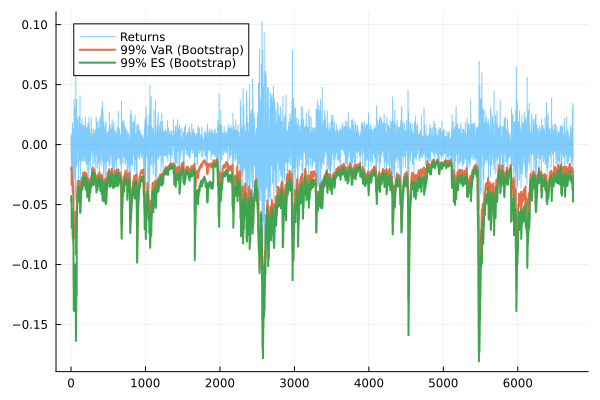

In [43]:
garch_model = fit(GARCH{1,1}, iseq_ret)

# Extract fitted volatilities using the volatilities function
vol_vec = ARCHModels.volatilities(garch_model)  # Explicitly call volatilities from ARCHModels

# Initialize arrays for VaR and ES results
var_forecasts_bootstrap = fill(NaN, length(iseq_ret))
es_forecasts_bootstrap = fill(NaN, length(iseq_ret))
breaches_bootstrap = fill(false, length(iseq_ret))
n_bootstrap = 1000  # Number of bootstrap samples

# Start from the 251st observation
for i in 251:length(iseq_ret)
    # Get the previous 100 observations
    historical_window = iseq_ret[i-250:i-1]

    # Apply GARCH rescaling BEFORE resampling
    historical_window_garch = historical_window ./ vol_vec[i-250:i-1]

    # Initialize arrays to store bootstrap VaR and ES estimates
    bootstrap_vars = zeros(n_bootstrap)
    bootstrap_es = zeros(n_bootstrap)

    # Perform bootstrap resampling
    for b in 1:n_bootstrap
        # Draw a bootstrap sample
        bootstrap_sample = sample(historical_window_garch, 250, replace=true)
        
        bootstrap_vars[b] = quantile(bootstrap_sample, 0.01)
        es_sample = bootstrap_sample[bootstrap_sample .< bootstrap_vars[b]]

        if length(es_sample) > 0
            bootstrap_es[b] = mean(es_sample)
        else
            bootstrap_es[b] = bootstrap_vars[b]  # Assign VaR as fallback ES
        end        
    end

    # Average the bootstrap VaR and ES estimates and scale back
    var_forecasts_bootstrap[i] = mean(bootstrap_vars) * vol_vec[i]
    es_forecasts_bootstrap[i] = mean(bootstrap_es) * vol_vec[i]

    # Check for breaches
    breaches_bootstrap[i] = iseq_ret[i] < var_forecasts_bootstrap[i]
end

# Calculate breach rate
breach_rate = mean(breaches_bootstrap)
num_breaches = sum(breaches_bootstrap)
total_obs = length(iseq_ret) - 250

# Calculate average VaR and ES
avg_var_bootstrap = mean(var_forecasts_bootstrap[251:end])
avg_es_bootstrap = mean(es_forecasts_bootstrap[251:end])

println("Number of breaches: $num_breaches")
println("Number of observations: $total_obs")
println("Breach rate: $(round(breach_rate * 100, digits=2))%")
println("Expected breach rate: 1.00%")
println("Average VaR with Bootstrap: $(round(avg_var_bootstrap * -1_000_000, digits=2)) EUR")
println("Average ES with Bootstrap: $(round(avg_es_bootstrap * -1_000_000, digits=2)) EUR")

# Plot the returns and VaR
plot(iseq_ret[251:end], label="Returns", alpha=0.5)
plot!(var_forecasts_bootstrap[251:end], label="99% VaR (Bootstrap)", linewidth=2)
plot!(es_forecasts_bootstrap[251:end], label="99% ES (Bootstrap)", linewidth=2)

A direct comparison is difficult given that we used two different confidence levels and sampled a longer period of days, which may give a more accurate representation of the distribution of returns  The breach rate (1.16%) is very close to the expected one (1.00%), indicating that the model is a good fit.

We now perform again the Bootstrap, this time with the Gaussian assumption:

Number of breaches: 123
Number of observations: 6743
Breach rate: 1.76%
Expected breach rate: 1.00%
Average VaR (Gaussian): 28301.55 EUR
Average ES (Gaussian): 32424.08 EUR


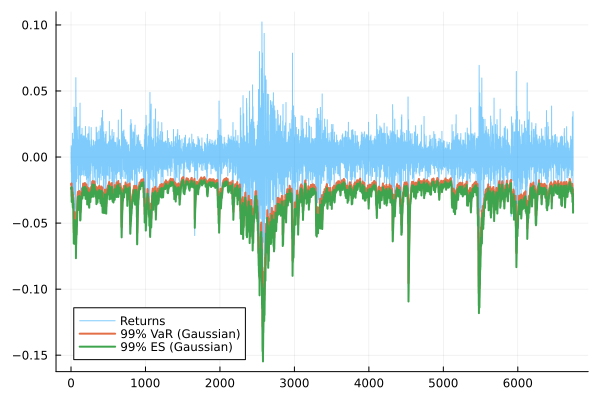

In [50]:
garch_model = fit(GARCH{1,1}, iseq_ret)

# Extract fitted volatilities
vol_vec = ARCHModels.volatilities(garch_model)

# Initialize arrays for VaR and ES results
var_forecasts_gaussian = fill(NaN, length(iseq_ret))
es_forecasts_gaussian = fill(NaN, length(iseq_ret))
breaches_gaussian = fill(false, length(iseq_ret))

# 99% Gaussian VaR and ES multipliers
z_99 = quantile(Normal(0,1), 0.01)  # ≈ -2.33
es_multiplier = pdf(Normal(0,1), z_99) / 0.01  # ≈ 2.66

# Start from the 251st observation
for i in 251:length(iseq_ret)
    # Compute Gaussian VaR and ES
    var_forecasts_gaussian[i] = z_99 * vol_vec[i]
    es_forecasts_gaussian[i] = es_multiplier * vol_vec[i]

    # Check for breaches
    breaches_gaussian[i] = iseq_ret[i] < var_forecasts_gaussian[i]
end

# Calculate breach rate
breach_rate = mean(breaches_gaussian)
num_breaches = sum(breaches_gaussian)
total_obs = length(iseq_ret) - 250

# Calculate average VaR and ES
avg_var_gaussian = mean(var_forecasts_gaussian[251:end])
avg_es_gaussian = mean(es_forecasts_gaussian[251:end])

println("Number of breaches: $num_breaches")
println("Number of observations: $total_obs")
println("Breach rate: $(round(breach_rate * 100, digits=2))%")
println("Expected breach rate: 1.00%")
println("Average VaR (Gaussian): $(round(avg_var_gaussian * -1_000_000, digits=2)) EUR")
println("Average ES (Gaussian): $(round(avg_es_gaussian * 1_000_000, digits=2)) EUR")

# Plot the returns and VaR
plot(iseq_ret[251:end], label="Returns", alpha=0.5)
plot!(var_forecasts_gaussian[251:end], label="99% VaR (Gaussian)", linewidth=2)
plot!(-es_forecasts_gaussian[251:end], label="99% ES (Gaussian)", linewidth=2)

The Bootstrap historical model performed a better fit than the Bootstrap Gaussian assumption, as the breach rate for the Gaussian assumption (1.76%) is higher.

In this case we have used 250 days rather than 100 so by construction the volatility will most likely change from the values in 1b), as with estimates for ES and VaR.

This is a reverse of the results that we obtained in part (a), where the Gaussian performed better than the historical model. This could be possibly due to bootstrapping and the use of a larger sample, which make the empirical distribution more realistic.

### Question 2a

We first compute the option value under a 4-period binomial for the American put:

In [35]:
# Function to calculate option prices using the Binomial Model
function binomial_option_pricing(cp, S, K, r, T, σ, n)
    # --- Calculation Other Values ----------------------------------------------
    dt = T / n              # Time step
    u = exp(σ * sqrt(dt))   # Up move factor
    d = 1 / u              # Down move factor
    p = (exp(r * dt) - d) / (u - d)  # Risk-neutral probability

    # --- Define Result Matrices -------------------------------------------------
    opt_val_american = zeros(n+1, n+1)  # American option price matrix
    opt_val_european = zeros(n+1, n+1)  # European option price matrix
    S_val = zeros(n+1, n+1)    # Stock price matrix

    # Generate the Underlying Stock Price Tree ----------
    S_val[1,1] = S
    for i in 2:n+1
        S_val[i,1] = S_val[i-1,1] * u
        for j in 2:i
            S_val[i,j] = S_val[i-1,j-1] * d
        end
    end

    # Backward recursion for option price -----
    for j in 1:n+1
        opt_val_american[n+1,j] = max(0, cp * (S_val[n+1,j] - K))  # Payoff at T
        opt_val_european[n+1,j] = opt_val_american[n+1,j]  # European option same at T
    end

    for i in n:-1:1
        for j in 1:i
            disc_val = (p * opt_val_european[i+1,j] + (1 - p) * opt_val_european[i+1,j+1]) / exp(r * dt)
            opt_val_european[i,j] = disc_val  # No early exercise allowed

            disc_val = (p * opt_val_american[i+1,j] + (1 - p) * opt_val_american[i+1,j+1]) / exp(r * dt)
            opt_val_american[i,j] = max(disc_val, cp * (S_val[i,j] - K))  # Allows early exercise
        end
    end

    return opt_val_european[1,1], opt_val_american[1,1]
end

european, american = binomial_option_pricing(-1, 10.0, 10.5, 0.04, 0.25, 0.2, 4)

@printf("Using Binomial method: \n")
@printf("The price of the European put option is %.5f.\n",  european)
@printf("The price of the American put option is %.5f.\n",  american)

Using Binomial method: 
The price of the European put option is 0.65601.
The price of the American put option is 0.67473.


We now move on to the Hybrid model:

In [36]:
# Function to calculate European & American option prices using Hybrid Binomial-Black-Scholes Model
function hybrid_binomial_black_scholes(cp, S, K, r, T, σ, n, m)
    # --- Calculation Other Values ----------------------------------------------
    dt = T / n              # Time step
    u = exp(σ * sqrt(dt))   # Up move factor
    d = 1 / u              # Down move factor
    p = (exp(r * dt) - d) / (u - d)  # Risk-neutral probability
    

    # --- Define Result Matrices -------------------------------------------------
    opt_val_american = zeros(n+1, n+1)  # American option price matrix
    opt_val_european = zeros(n+1, n+1)  # European option price matrix
    S_val = zeros(n+1, n+1)    # Stock price matrix

    # Generate the Underlying Stock Price Tree ----------
    S_val[1,1] = S
    for i in 2:n+1
        S_val[i,1] = S_val[i-1,1] * u
        for j in 2:i
            S_val[i,j] = S_val[i-1,j-1] * d
        end
    end

    # --- Black-Scholes Formula for Final Steps --------------------------------
    function black_scholes(S, K, T, r, σ, cp)
        d1 = (log(S/K) + (r + 0.5 * σ^2) * T) / (σ * sqrt(T))
        d2 = d1 - σ * sqrt(T)
        N = Normal(0,1)
        
        if cp == 1  # Call option
            return S * cdf(N, d1) - K * exp(-r * T) * cdf(N, d2)
        else  # Put option
            return K * exp(-r * T) * cdf(N, -d2) - S * cdf(N, -d1)
        end
    end

    # Apply Black-Scholes pricing for last 'm' steps
    for j in 1:n+1
        if j >= n-m+1  # Apply Black-Scholes at m steps before expiry
            opt_val_european[n+1,j] = black_scholes(S_val[n+1,j], K, T/n, r, σ, cp)
            opt_val_american[n+1,j] = opt_val_european[n+1,j]  # American starts the same
        else
            opt_val_american[n+1,j] = max(0, cp * (S_val[n+1,j] - K))  # Standard payoff
            opt_val_european[n+1,j] = opt_val_american[n+1,j]
        end
    end

    # --- Backward recursion for option price --------------------------------
    for i in n:-1:1
        for j in 1:i
            disc_val = (p * opt_val_european[i+1,j] + (1 - p) * opt_val_european[i+1,j+1]) / exp(r * dt)
            opt_val_european[i,j] = disc_val  # No early exercise allowed

            disc_val = (p * opt_val_american[i+1,j] + (1 - p) * opt_val_american[i+1,j+1]) / exp(r * dt)
            opt_val_american[i,j] = max(disc_val, cp * (S_val[i,j] - K))  # Allows early exercise
        end
    end


   
    return opt_val_european[1,1], opt_val_american[1,1]
end

european, american  = hybrid_binomial_black_scholes(-1, 10.0, 10.5, 0.04, 0.25, 0.2, 4, 1)

@printf("Using Hybrid Binomial-Black-Scholes method: \n")
@printf("The price of the European put option is %.5f.\n", european)
@printf("The price of the American put option is %.5f.\n", american)

Using Hybrid Binomial-Black-Scholes method: 
The price of the European put option is 0.64843.
The price of the American put option is 0.67473.


The European prices were all lower than the American prices which is a good sign. The estimate for the European via the Binomial was slightly higher than via the Hybrid but the American estimates were very similar.

In theory, the Hybrid model should be more accurate than the Binomial, due to the fact that we are using the Black-Scholes Model in the final steps of the tree.

# Question 2b

We now repeat the same as above, for different exercise levels.

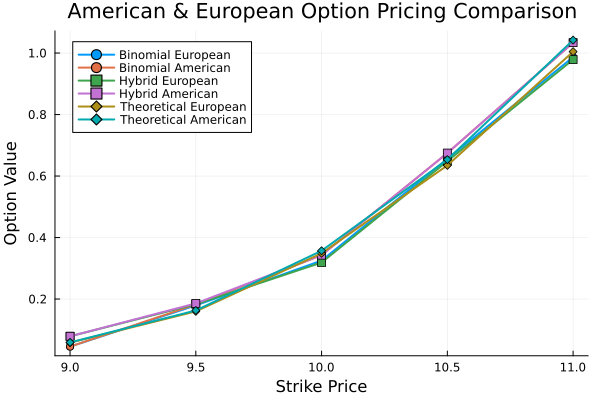

In [37]:
using Plots

# Define the strike prices
strike_prices = [9.00, 9.50, 10.00, 10.50, 11.00]

# Compute option values using your predefined functions
binomial_european_values = [
    binomial_option_pricing(-1, 10.0, K, 0.04, 0.25, 0.2, 4)[1] for K in strike_prices
]

binomial_american_values = [
    binomial_option_pricing(-1, 10.0, K, 0.04, 0.25, 0.2, 4)[2] for K in strike_prices
]

hybrid_european_values = [
    hybrid_binomial_black_scholes(-1, 10.0, K, 0.04, 0.25, 0.2, 4, 1)[1] for K in strike_prices
]

hybrid_american_values = [
    hybrid_binomial_black_scholes(-1, 10.0, K, 0.04, 0.25, 0.2, 4, 1)[2] for K in strike_prices
]

# From wolfram
theoretical_european_values = [
    0.05817423541854042, 0.16003746294310794, 0.34892230265609653, 0.6346594964450883, 1.0045253618235839
]

# From Wolfram
theoretical_american_values = [
    0.05902912417322874, 0.16300187670099925, 0.3571253349226725, 0.6534911108149373, 1.0422392515644106
]
    

# Plot the results
plot(
    strike_prices, binomial_european_values, 
    label="Binomial European", marker=:circle, linewidth=2
)
plot!(
    strike_prices, binomial_american_values, 
    label="Binomial American", marker=:circle, linewidth=2
)
plot!(
    strike_prices, hybrid_european_values, 
    label="Hybrid European", marker=:square, linewidth=2
)
plot!(
    strike_prices, hybrid_american_values, 
    label="Hybrid American", marker=:square, linewidth=2
)

plot!(
    strike_prices, theoretical_european_values, 
    label="Theoretical European", marker=:diamond, linewidth=2
)

plot!(
    strike_prices, theoretical_american_values, 
    label="Theoretical American", marker=:diamond, linewidth=2
)

# Add labels, title, and legend
xlabel!("Strike Price")
ylabel!("Option Value")
title!("American & European Option Pricing Comparison")

NOTE: All of the methods yielded relatively similar results overall. In reality, we only used a four step model to estimate the price so we would expect to have an increase in accuracy as step size increased which is most likely what Wolfram Alpha is doing.

As expected, the American option's value is always higher than the European.